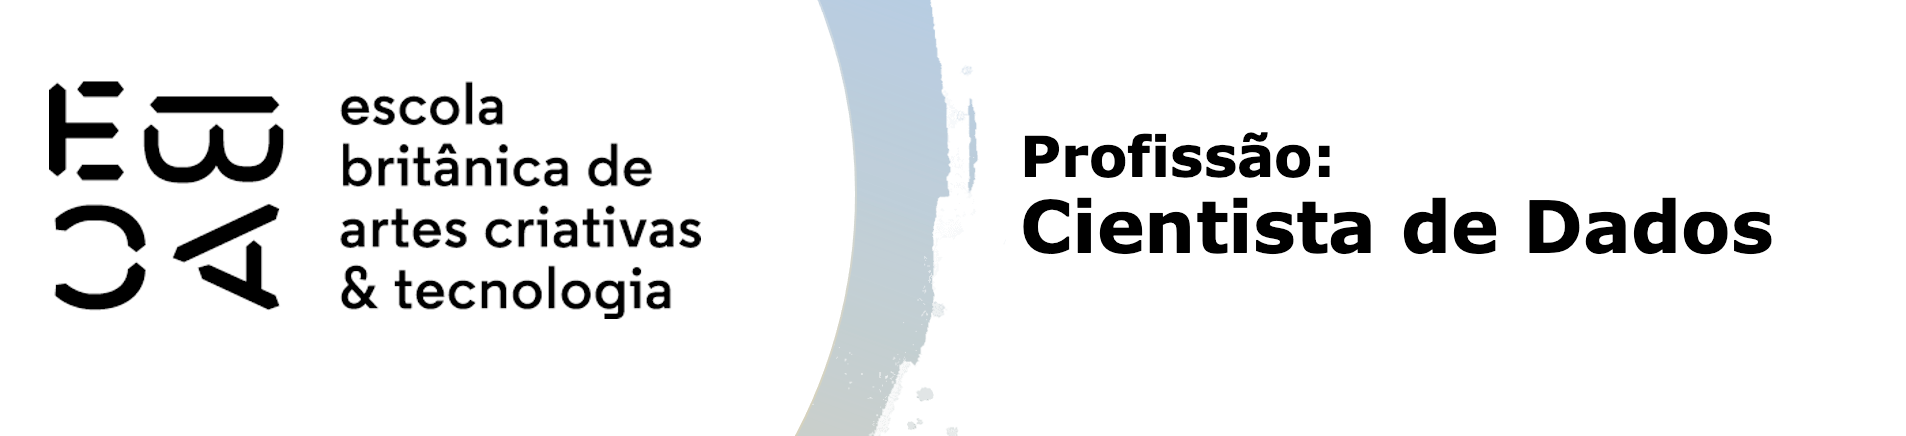

# Tarefa

Com base na tarefa realizada no módulo anterior, vamos fazer um diagnóstico do modelo.

Carregue a base ```previsao_de_renda2.csv```. Separe em uma base de treino e uma base de teste.

Vamos resgatar a melhor versão do modelo de previsão de renda que você fez para esta base. 

- Substitua missings pela média
- Rode novamente o modelo na base de treino (ou desenvolva-o caso não tenha o registro guardado). 

Este modelo deve prever a variável ```renda``` com base nas demais variáveis exceto ```data_ref``` e ```index```. Já vimos que a variável renda é melhor modelada com a transformação ```log()```, não se esqueça disso.

In [1]:
# Importando as bibliotecas
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import statsmodels.api as sm
import statsmodels.formula.api as smf
import seaborn as sns
from statsmodels.stats.outliers_influence import variance_inflation_factor as vif

In [2]:
# Acessando a Base de Dados
df = pd.read_csv('previsao_de_renda_II.csv', index_col=0)
df.head()

,index,sexo,posse_de_veiculo,posse_de_imovel,qtd_filhos,tipo_renda,educacao,estado_civil,tipo_residencia,idade,tempo_emprego,qt_pessoas_residencia,renda
data_ref,,,,,,,,,,,,,
2015-01-01,5762,M,S,N,0,Empresário,Superior completo,Casado,Casa,47,16.717808,2.0,11138.14
2015-01-01,1279,M,S,N,0,Assalariado,Superior incompleto,Casado,Casa,30,9.600000,2.0,2424.81
2015-01-01,14111,M,S,N,0,Assalariado,Superior completo,Casado,Casa,28,8.208219,2.0,13749.66
2015-01-01,8189,M,N,S,2,Assalariado,Médio,Casado,Casa,44,1.301370,4.0,2361.84
2015-01-01,1830,F,N,S,2,Assalariado,Superior completo,Casado,Casa,33,1.254795,4.0,790.78


In [3]:
# Verificando a quantidade de linhas e colunas do DataFrame
df.shape

(750000, 13)

In [4]:
# Reduzindo para 2% a base de dados para melhor demonstração desta atividade
# Com a base completa houve muita demora na execução de algumas tarefas
df.index = pd.to_datetime(df.index)
df['mes'] = df.index.month
df_amostra = df.groupby('mes').apply(lambda x: x.sample(frac=0.02, random_state=42)).reset_index(level=0, drop = True).drop(columns=['mes'])

In [5]:
# Resetar index
df_amostra.reset_index(inplace=True)

In [6]:
# Verificando a quantidade de linhas e colunas do DataFrame
df_amostra.shape

(15000, 14)

In [7]:
# Identificando os valores missing
df_amostra.isna().sum()

data_ref                    0
index                       0
sexo                        0
posse_de_veiculo            0
posse_de_imovel             0
qtd_filhos                  0
tipo_renda                  0
educacao                    0
estado_civil                0
tipo_residencia             0
idade                       0
tempo_emprego            2572
qt_pessoas_residencia       0
renda                       0
dtype: int64

In [8]:
# Substituíndo os valores missing pela média
media = df_amostra['tempo_emprego'].mean()
df_amostra['tempo_emprego'] = df_amostra['tempo_emprego'].copy().fillna(media)

In [9]:
# Preparando a base para a separação (3 últimos meses para a base de teste)
data_max = df_amostra['data_ref'].max()
data_inicio = data_max - pd.DateOffset(months=3)
df_treino = df_amostra[df_amostra['data_ref'] < data_inicio]
df_teste = df_amostra[df_amostra['data_ref'] >= data_inicio]

## Verifique as suposições do modelo

Faça uma análise para avaliar as suposições básicas:

- Os resíduos desse modelo possuem distribuição Normal (ou algo próximo)?
- Verifique a independência dos resíduos
    - Faça um gráfico dos resíduos versus os valores preditos
    - Avalie se há padrões dos resíduos versus cada uma das variáveis do modelo
    - Avalie se o valor médio dos resíduos aparenta ter relação com o mês de referência
- Avalie se a variância da variável resposta parece ser conforme os valores previstos.

Você considera que as suposições estão atendidas? Há algum impacto em eventuais desvios?

In [10]:
# Gerando o primeiro modelo
model1 = smf.ols('''np.log(renda) ~ sexo + posse_de_veiculo + posse_de_imovel + qtd_filhos
              + tipo_renda + educacao + estado_civil + tipo_residencia + idade
              + tempo_emprego + qt_pessoas_residencia''',data=df_treino).fit()

model1.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:          np.log(renda)   R-squared:                       0.445
Model:                            OLS   Adj. R-squared:                  0.444
Method:                 Least Squares   F-statistic:                     369.5
Date:                Sat, 18 May 2024   Prob (F-statistic):               0.00
Time:                        16:55:29   Log-Likelihood:                -14607.
No. Observations:               11072   AIC:                         2.926e+04
Df Residuals:                   11047   BIC:                         2.945e+04
Df Model:                          24                                         
Covariance Type:            nonrobust                                         
====================================================================================================
                                       coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------------------
Intercept                            7.7290      0.368     20.999      0.000       7.008       8.450
sexo[T.M]                            0.1571      0.020      7.712      0.000       0.117       0.197
posse_de_veiculo[T.S]               -0.0129      0.019     -0.668      0.504      -0.051       0.025
posse_de_imovel[T.S]                 0.1653      0.019      8.710      0.000       0.128       0.203
tipo_renda[T.Bolsista]               0.9165      0.641      1.429      0.153      -0.340       2.173
tipo_renda[T.Empresário]             0.1555      0.022      7.085      0.000       0.112       0.198
tipo_renda[T.Pensionista]           -0.2912      0.031     -9.335      0.000      -0.352      -0.230
tipo_renda[T.Servidor público]       0.1018      0.032      3.141      0.002       0.038       0.165
educacao[T.Médio]                    0.0184      0.081      0.228      0.820      -0.140       0.176
educacao[T.Pós graduação]            0.7162      0.379      1.891      0.059      -0.026       1.459
educacao[T.Superior completo]        0.1327      0.082      1.625      0.104      -0.027       0.293
educacao[T.Superior incompleto]     -0.0086      0.091     -0.094      0.925      -0.187       0.170
estado_civil[T.Separado]             0.2506      0.179      1.404      0.160      -0.099       0.601
estado_civil[T.Solteiro]             0.2449      0.176      1.391      0.164      -0.100       0.590
estado_civil[T.União]               -0.0117      0.033     -0.359      0.720      -0.076       0.052
estado_civil[T.Viúvo]                0.2237      0.181      1.237      0.216      -0.131       0.578
tipo_residencia[T.Casa]             -0.2245      0.070     -3.222      0.001      -0.361      -0.088
tipo_residencia[T.Com os pais]      -0.1882      0.080     -2.348      0.019      -0.345      -0.031
tipo_residencia[T.Comunitário]      -0.3671      0.141     -2.608      0.009      -0.643      -0.091
tipo_residencia[T.Estúdio]          -0.2699      0.131     -2.064      0.039      -0.526      -0.014
tipo_residencia[T.Governamental]    -0.2229      0.085     -2.623      0.009      -0.390      -0.056
qtd_filhos                          -0.2102      0.175     -1.201      0.230      -0.553       0.133
idade                                0.0046      0.001      4.027      0.000       0.002       0.007
tempo_emprego                        0.1291      0.002     85.618      0.000       0.126       0.132
qt_pessoas_residencia                0.2115      0.175      1.211      0.226      -0.131       0.554
==============================================================================
Omnibus:                       35.168   Durbin-Watson:                   1.261
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               33.833
Skew:             

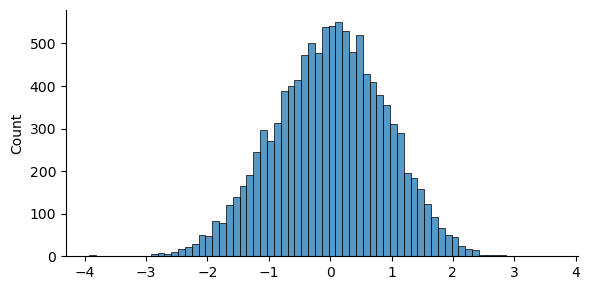

In [11]:
sns.displot(model1.resid, height=3, aspect=2);

**Avaliação:**
- Pode se dizer os resíduos desse modelo, conforme gráfico acima, possuem distribuição Normal (ou algo próximo).

#### Verificando a independência dos resíduos

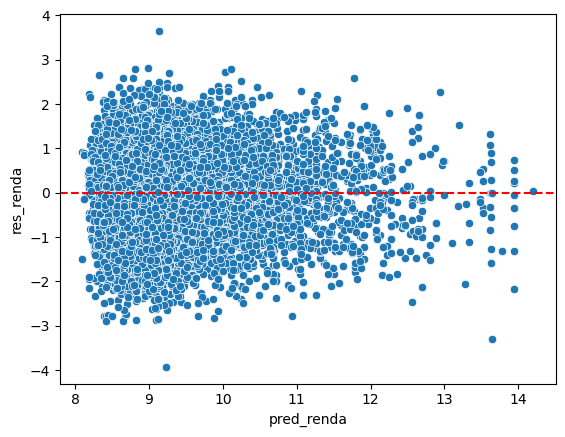

In [12]:
# Fazendo um gráfico dos resíduos versus os valores preditos
pd.options.mode.copy_on_write = True
df_treino['res_renda'] = model1.resid
df_treino['pred_renda'] = model1.fittedvalues
sns.scatterplot(x = 'pred_renda', y = 'res_renda', data = df_treino)
plt.axhline(y=0, color='r', linestyle='--')

#### Avaliando se há padrões dos resíduos versus cada uma das variáveis do modelo

<Axes: xlabel='sexo', ylabel='res_renda'>

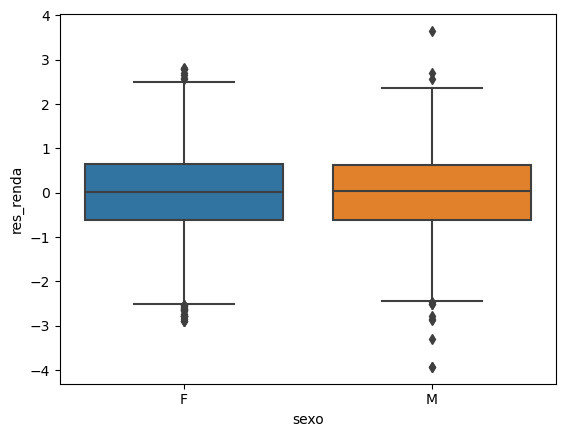

In [13]:
# resíduos versus sexo
sns.boxplot(x = 'sexo', y = 'res_renda', data = df_treino)

<Axes: xlabel='posse_de_veiculo', ylabel='res_renda'>

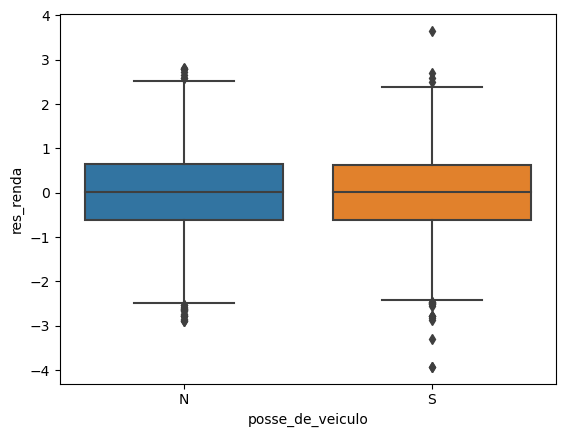

In [14]:
# resíduos versus posse_de_veiculo
sns.boxplot(x = 'posse_de_veiculo', y = 'res_renda', data = df_treino)

<Axes: xlabel='posse_de_imovel', ylabel='res_renda'>

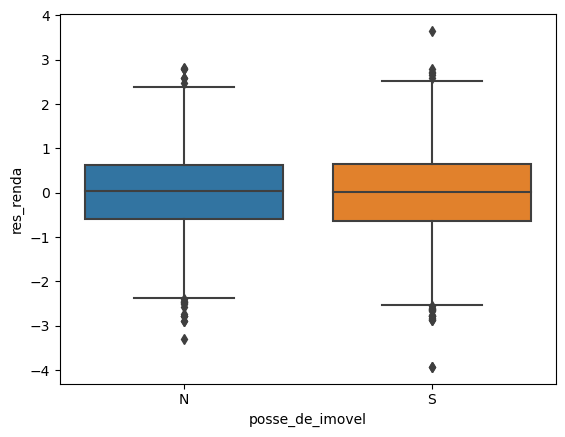

In [15]:
# resíduos versus posse_de_imovel
sns.boxplot(x = 'posse_de_imovel', y = 'res_renda', data = df_treino)

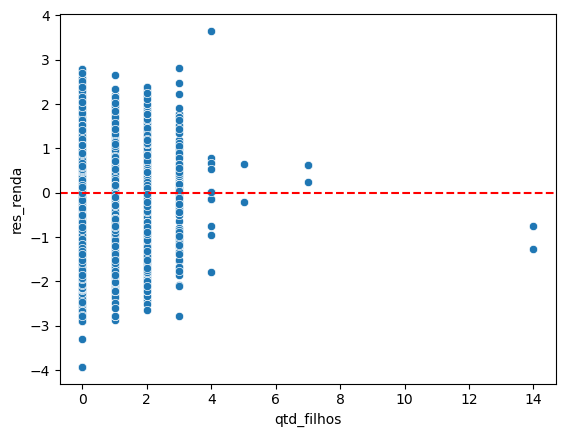

In [16]:
# resíduos versus qtd_filhos
sns.scatterplot(x = 'qtd_filhos', y = 'res_renda', data = df_treino)
plt.axhline(y=0, color='r', linestyle='--')

<Axes: xlabel='tipo_renda', ylabel='res_renda'>

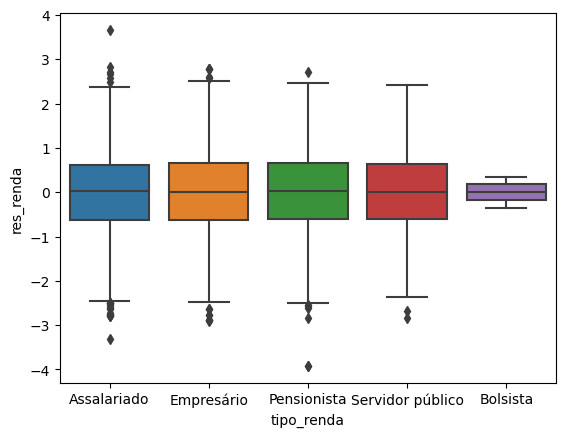

In [17]:
# resíduos versus tipo_renda
sns.boxplot(x = 'tipo_renda', y = 'res_renda', data = df_treino)

<Axes: xlabel='educacao', ylabel='res_renda'>

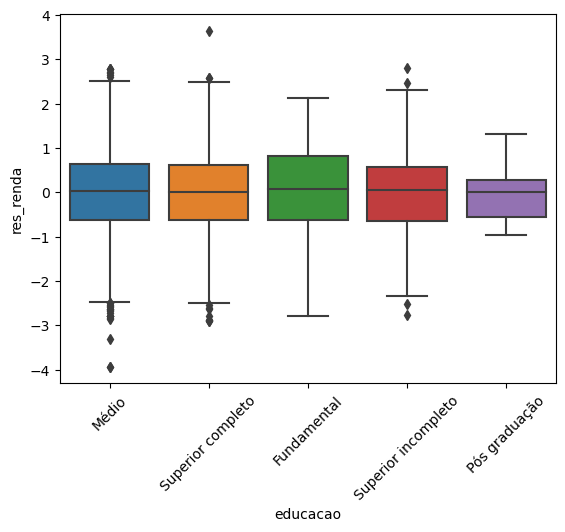

In [18]:
# resíduos versus educacao
plt.xticks(rotation=45)
sns.boxplot(x = 'educacao', y = 'res_renda', data = df_treino)

<Axes: xlabel='estado_civil', ylabel='res_renda'>

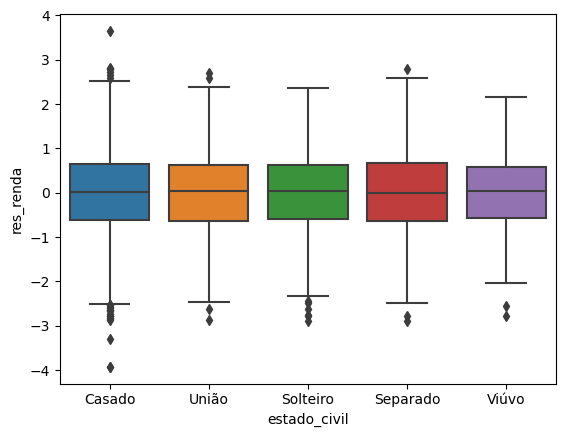

In [19]:
# resíduos versus estado_civil
sns.boxplot(x = 'estado_civil', y = 'res_renda', data = df_treino)

<Axes: xlabel='tipo_residencia', ylabel='res_renda'>

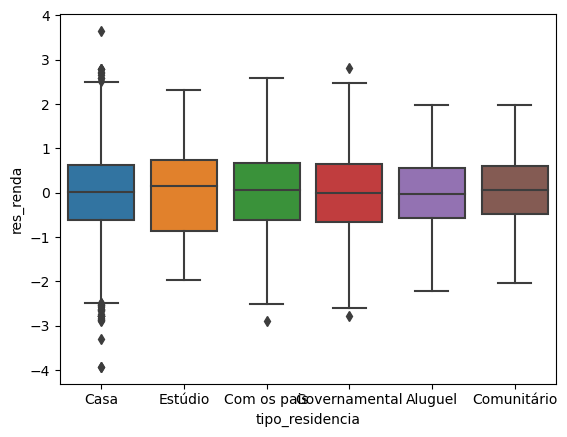

In [20]:
# resíduos versus tipo_residencia
sns.boxplot(x = 'tipo_residencia', y = 'res_renda', data = df_treino)

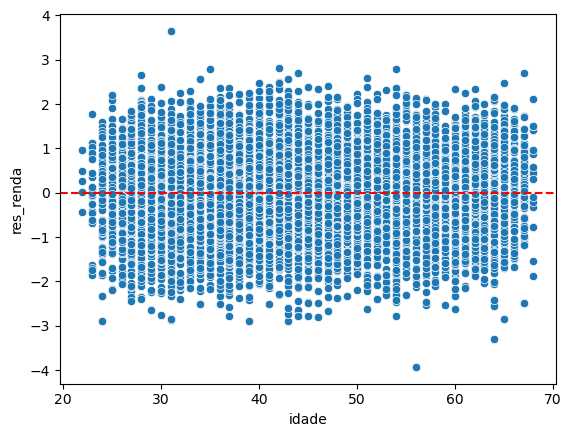

In [21]:
# resíduos versus idade
sns.scatterplot(x = 'idade', y = 'res_renda', data = df_treino)
plt.axhline(y=0, color='r', linestyle='--')

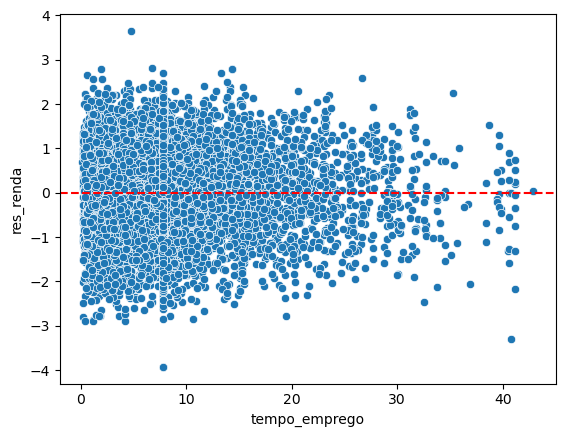

In [22]:
# resíduos versus tempo_emprego
sns.scatterplot(x = 'tempo_emprego', y = 'res_renda', data = df_treino)
plt.axhline(y=0, color='r', linestyle='--')

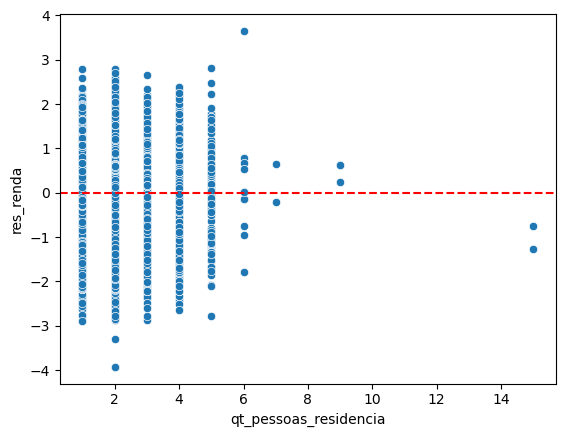

In [23]:
# resíduos versus qt_pessoas_residencia
sns.scatterplot(x = 'qt_pessoas_residencia', y = 'res_renda', data = df_treino)
plt.axhline(y=0, color='r', linestyle='--')

**Avaliação:**
- Não há sinalização de padrão analisando os resíduos verso cada uma das variáveis do modelo

#### Avaliando se o valor médio dos resíduos aparenta ter relação com o mês de referência

In [24]:
# Gerando as variáveis 'mes' e 'ano'
df_treino['mes'] = df_treino['data_ref'].dt.month
df_treino['ano'] = df_treino['data_ref'].dt.year

In [25]:
# Realizando o agrupamento pelo mês e calculando a média da variável 'res_renda'
df_treino_agr = df_treino.groupby('mes')['res_renda'].mean().to_frame()
df_treino_agr.rename(columns={'res_renda': 'media_res_renda'}, inplace=True)

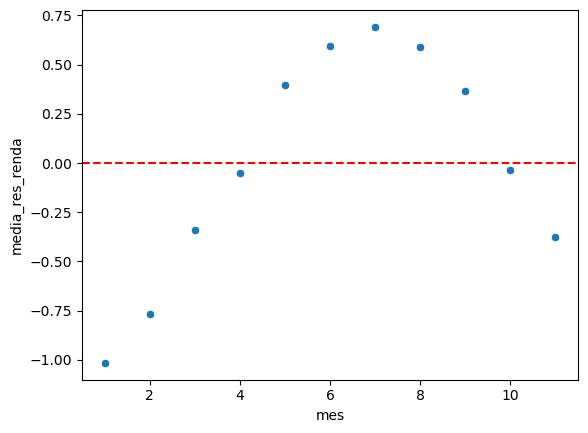

In [26]:
# Visualizando graficamente
sns.scatterplot(x = 'mes', y = 'media_res_renda', data = df_treino_agr)
plt.axhline(y=0, color='r', linestyle='--')

**Avaliação:**
- A média dos resíduos aumento até atingir o mês 7, passando a decair a partir daí, representando uma figura de uma parábola.

#### Avaliando se a variância da variável resposta parece ser conforme os valores previstos.

- Com a aplicação da log para a variável resposta os gráficos de dispersão dos resíduos x valores previstos, bem como, os de dispersão dos resíduos x variáveis explicativas, apresentam boa distribuição dos resíduos, o que colabora para que a variância da variável resposta pareça estar conforme os valores previstos.
- Esta transformação da variável resposta ajuda a corrigir casos de heterocedasticidade em função da não linearidade da relação entre a variável renda e as variáveis explicativas.

## Outliers

Avalie os *studentized residuals*, verifique se há pontos que parecem ser discrepantes.

Avalie se há pontos influentes.

In [27]:
df_treino['st_res'] = model1.get_influence().resid_studentized_internal

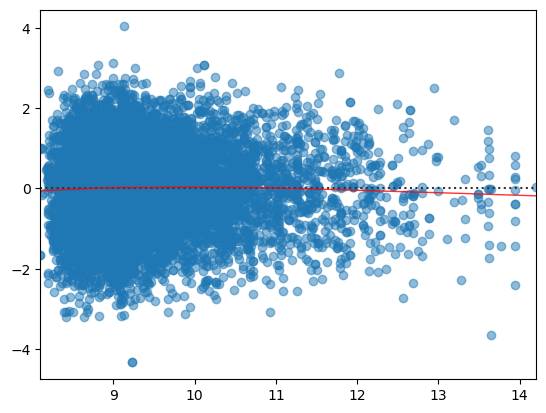

In [28]:
sns.residplot(x=model1.fittedvalues, y=model1.get_influence().resid_studentized_internal, lowess=True, 
                     scatter_kws={'alpha': 0.5}, 
                     line_kws={'color': 'red', 'lw': 1, 'alpha': 0.8});

In [29]:
df_treino.head()

,data_ref,index,sexo,posse_de_veiculo,posse_de_imovel,qtd_filhos,tipo_renda,educacao,estado_civil,tipo_residencia,idade,tempo_emprego,qt_pessoas_residencia,renda,res_renda,pred_renda,mes,ano,st_res
2,2015-01-01,4527,F,N,N,0,Assalariado,Médio,Casado,Casa,53,3.430137,2.0,1324.97,-1.442295,8.631440,1,2015,-1.592380
10,2015-01-01,2428,M,N,S,0,Assalariado,Médio,Casado,Casa,51,9.539726,2.0,6646.19,-0.931678,9.733477,1,2015,-1.028559
11,2015-01-01,10293,F,S,S,0,Empresário,Médio,Casado,Casa,50,19.309589,2.0,76588.68,0.270519,10.975685,1,2015,0.298720
12,2015-01-01,1063,F,N,S,1,Assalariado,Médio,Casado,Casa,28,7.600000,3.0,1468.61,-1.929813,9.221884,1,2015,-2.130463
13,2015-01-01,11526,F,S,S,0,Assalariado,Superior completo,Casado,Casa,56,1.715068,2.0,3145.66,-0.636691,8.690470,1,2015,-0.703077


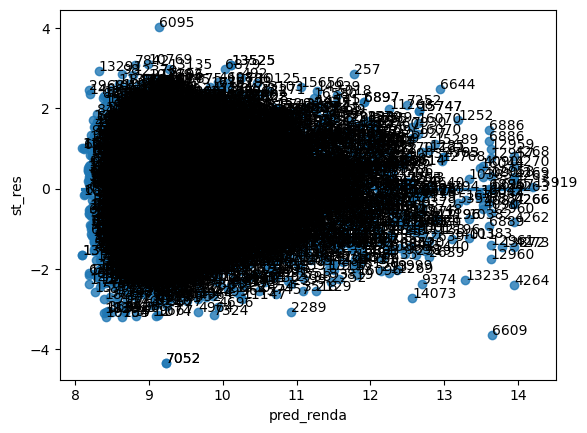

In [30]:
# Variância
fig, ax = plt.subplots()

sns.regplot(x = 'pred_renda', y = 'st_res', data=df_treino, ax=ax)

for i, txt in enumerate(df_treino['index'].values):
   ax.annotate(str(txt), (model1.predict()[i], model1.get_influence().resid_studentized_internal[i]))

In [31]:
# Pontos influentes

CPU times: total: 13min 11s
Wall time: 4min 28s


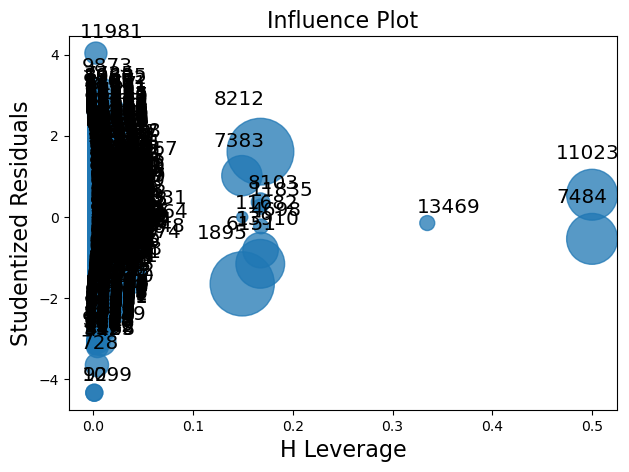

In [32]:
%%time
 
fig = sm.graphics.influence_plot(model1, criterion="cooks")
fig.tight_layout(pad=1.0)

In [33]:
# Gerando DataFrame com os pontos influentes
influente = model1.get_influence()
leverage = influente.hat_matrix_diag
df_treino['leverage'] = leverage
df_treino_inf = df_treino[df_treino['leverage']>= 0.1]

In [34]:
# Visualizando estes dados
qtde_influente,_ = df_treino_inf.shape
print('Total de Pontos Influentes = ',qtde_influente)
df_treino_inf

Total de Pontos Influentes =  12


,data_ref,index,sexo,posse_de_veiculo,posse_de_imovel,qtd_filhos,tipo_renda,educacao,estado_civil,tipo_residencia,idade,tempo_emprego,qt_pessoas_residencia,renda,res_renda,pred_renda,mes,ano,st_res,leverage
1895,2015-01-01,16558,M,N,S,1,Empresário,Médio,União,Casa,34,5.767123,1.0,1822.64,-1.382587,8.890629,1,2015,-1.654276,0.149337
4698,2015-03-01,15169,M,S,S,0,Assalariado,Pós graduação,Casado,Casa,61,0.534247,2.0,9010.57,-0.195396,9.301550,3,2015,-0.236417,0.168115
6151,2015-04-01,5493,F,S,S,1,Empresário,Pós graduação,Casado,Casa,33,2.682192,3.0,4870.20,-0.959358,9.450249,4,2015,-1.160277,0.167419
7383,2015-05-01,16530,F,N,S,1,Assalariado,Médio,Casado,Casa,33,2.134247,1.0,7819.18,0.848162,8.116173,5,2015,1.014625,0.148991
7484,2015-05-01,595,F,N,S,0,Bolsista,Superior completo,Casado,Casa,51,10.695890,2.0,33108.69,-0.348862,10.756413,5,2015,-0.544456,0.500000
8103,2015-06-01,818,F,N,S,1,Assalariado,Pós graduação,União,Casa,47,20.704110,3.0,160430.86,0.298774,11.686845,6,2015,0.361411,0.167717
8212,2015-06-01,7981,F,N,S,1,Assalariado,Pós graduação,Solteiro,Casa,34,7.586301,2.0,81396.83,1.328265,9.978826,6,2015,1.606635,0.167617
11023,2015-09-01,596,F,N,S,0,Bolsista,Superior completo,Casado,Casa,51,10.695890,2.0,66521.14,0.348862,10.756413,9,2015,0.544456,0.500000
11682,2015-09-01,16558,M,N,S,1,Empresário,Médio,União,Casa,34,5.767123,1.0,7226.31,-0.005145,8.890629,9,2015,-0.006156,0.149337
11835,2015-09-01,5494,F,S,S,1,Empresário,Pós graduação,Casado,Casa,33,2.682192,3.0,15641.58,0.207439,9.450249,9,2015,0.250884,0.167419


**Avaliação:**
- Dos 12 (doze) pontos em análise considero que os pontos 4698, 7383 e 13469 não apresentam distorções, sendo considerados normais para mim. Os demais apresentam renda incompatíveis com o tipo de renda. 

## Multicolinearidade

Avalie se há questões relacionadas a multicolinearidade através de pelo menos:

- Matriz de correlação de Spearman
- VIF

In [35]:
# Ajustando o DataFrame
df_treino_dummies = pd.get_dummies(df_treino, drop_first=True)

In [36]:
# Selecionando as variáveis
variaveis = ['qtd_filhos', 'idade', 'tempo_emprego',
       'qt_pessoas_residencia', 'sexo_M', 'posse_de_veiculo_S',
       'posse_de_imovel_S', 'tipo_renda_Bolsista', 'tipo_renda_Empresário',
       'tipo_renda_Pensionista', 'tipo_renda_Servidor público',
       'educacao_Médio', 'educacao_Pós graduação',
       'educacao_Superior completo', 'educacao_Superior incompleto',
       'estado_civil_Separado', 'estado_civil_Solteiro', 'estado_civil_União',
       'estado_civil_Viúvo', 'tipo_residencia_Casa',
       'tipo_residencia_Com os pais', 'tipo_residencia_Comunitário',
       'tipo_residencia_Estúdio', 'tipo_residencia_Governamental']

<Axes: >

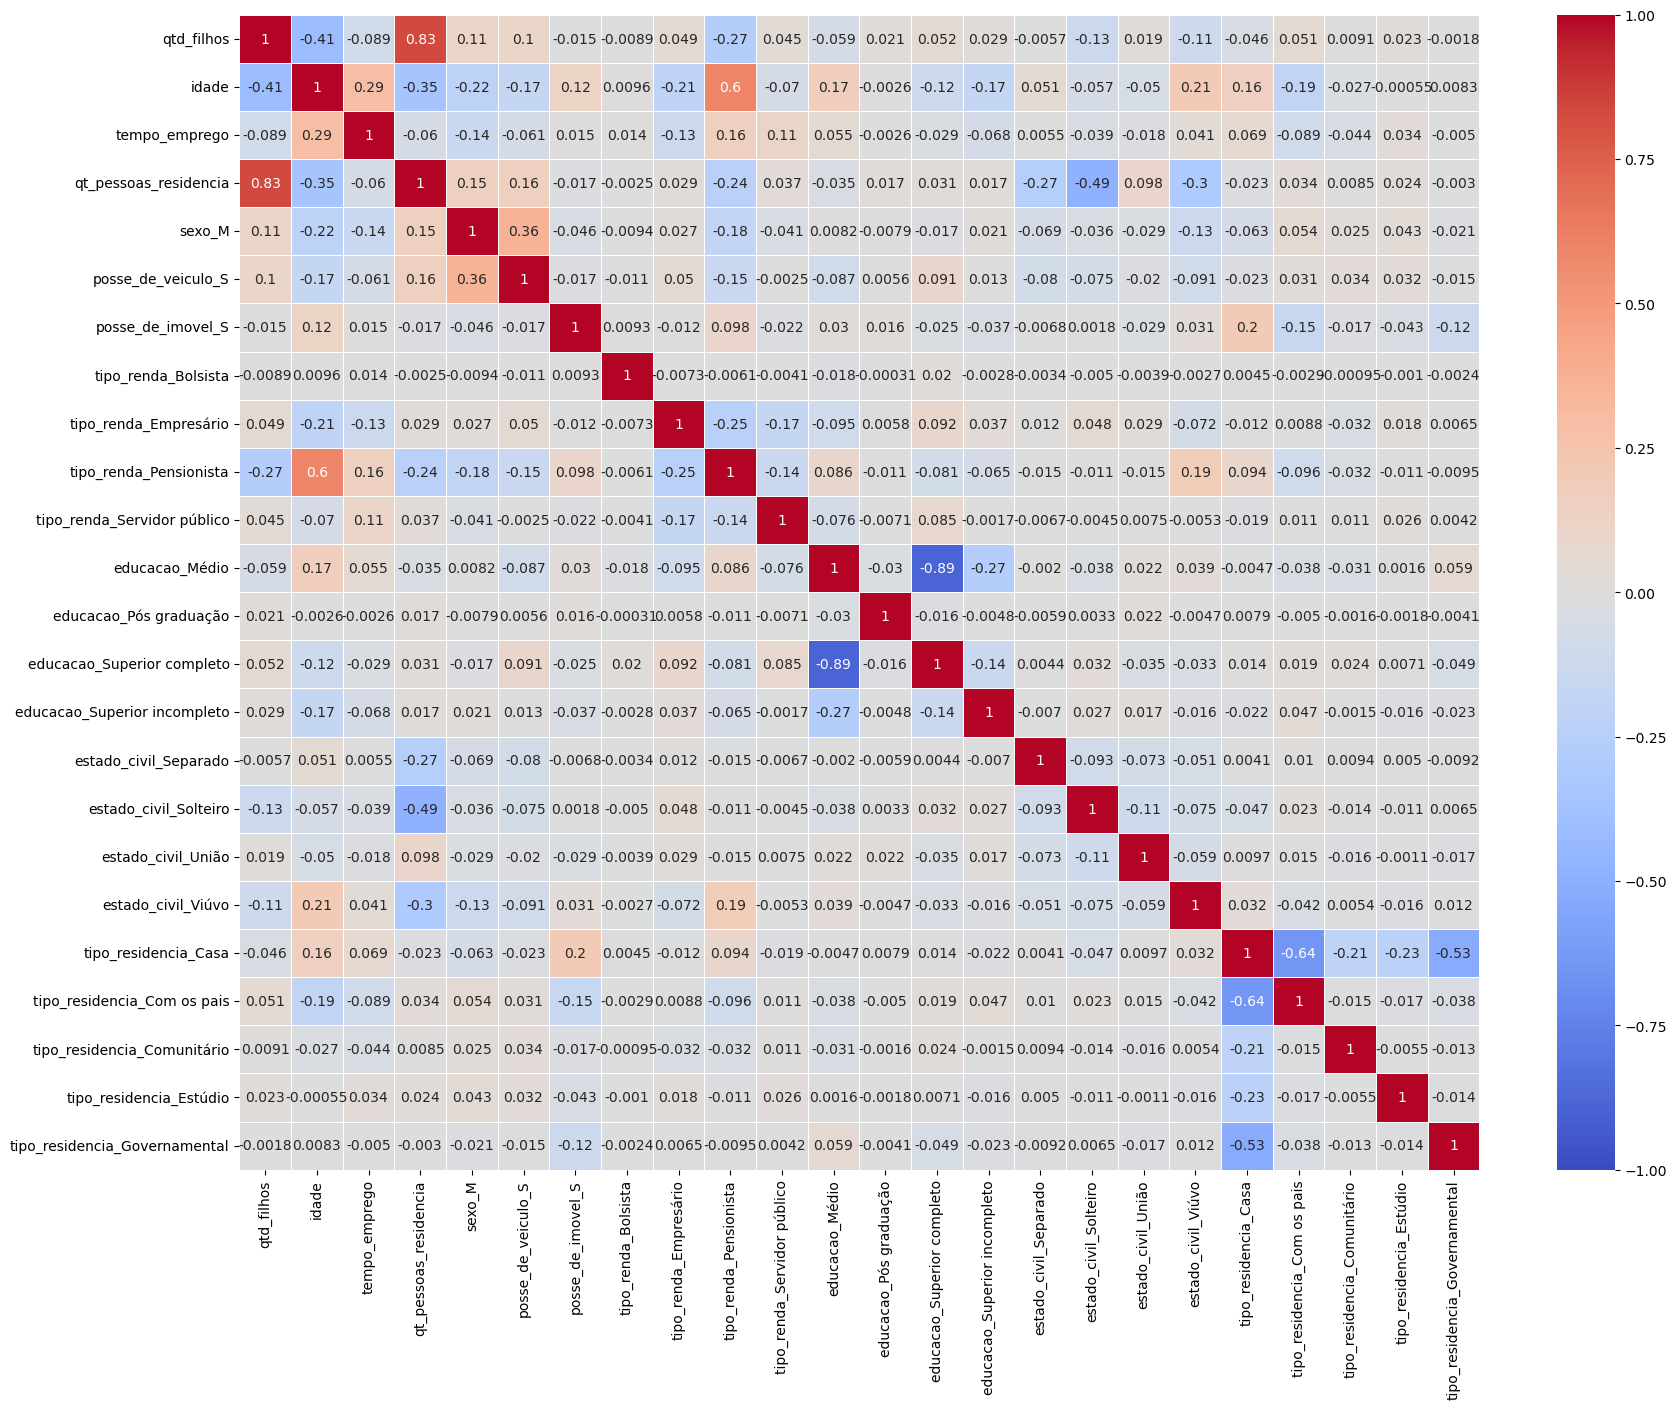

In [37]:
# Calculando a correlação de Spearman
spearman = df_treino_dummies[variaveis].corr(method='spearman')
plt.figure(figsize=(20,15))
sns.heatmap(spearman, annot=True, cmap='coolwarm', vmin=-1, vmax=1, cbar=True, linewidths=0.5)

In [38]:
df_treino_dum1 = df_treino_dummies[variaveis].astype(float)

In [39]:
# Calculando o Variance Inflation Factor (ou VIF)
#df_treino_dum1 = np.array(df_treino_dummies, dtype=float)
vif(df_treino_dum1, 3)

234.28431046867283

In [40]:
vars_vif = pd.DataFrame()
vars_vif["VIF Factor"] = [vif(df_treino_dum1, i) for i in range(df_treino_dum1.shape[1])]
vars_vif["Feature"] = variaveis

vars_vif.round(2)

,VIF Factor,Feature
0,33.89,qtd_filhos
1,35.26,idade
2,3.01,tempo_emprego
3,234.28,qt_pessoas_residencia
4,1.82,sexo_M
5,1.93,posse_de_veiculo_S
6,3.28,posse_de_imovel_S
7,1.00,tipo_renda_Bolsista
8,1.49,tipo_renda_Empresário
9,2.24,tipo_renda_Pensionista


**Avaliação:**
- Há sinalização de multicolinearidade muito forte indicada pelos dois métodos para as variáveis: qt_pessoas_residencia, educacao_Médio e tipo_residencia_Casa.

## Ajustes

Faça os ajustes que julgar necessários no modelo e compare as métricas de desempenho do modelo original e ajustado na base de testes.

In [41]:
# Retirando itens não discrepantes
df_treino_drop = df_treino_inf.drop([4698, 7383, 13469], axis=0) 

In [42]:
# Ajustando o DataFrame
mask = ~df_treino.isin(df_treino_drop.to_dict(orient='list')).all(axis=1)
df_treino_ajustado = df_treino[mask]

In [43]:
# Removendo as variáveis menos significantes
df_treino_ajustado = df_treino_ajustado[(df_treino_ajustado.educacao != 'Médio')&(df_treino_ajustado.tipo_residencia != 'Casa')]
df_treino_ajustado.shape

(409, 20)

In [44]:
# Gerando o primeiro modelo após os ajustes
model2 = smf.ols('''np.log(renda) ~ sexo + posse_de_veiculo + posse_de_imovel + qtd_filhos
              + tipo_renda + educacao + estado_civil + tipo_residencia + idade
              + tempo_emprego''',data=df_treino_ajustado).fit()

model2.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:          np.log(renda)   R-squared:                       0.353
Model:                            OLS   Adj. R-squared:                  0.321
Method:                 Least Squares   F-statistic:                     11.15
Date:                Sat, 18 May 2024   Prob (F-statistic):           8.71e-27
Time:                        17:05:33   Log-Likelihood:                -527.69
No. Observations:                 409   AIC:                             1095.
Df Residuals:                     389   BIC:                             1176.
Df Model:                          19                                         
Covariance Type:            nonrobust                                         
====================================================================================================
                                       coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------------------
Intercept                            7.5014      0.393     19.065      0.000       6.728       8.275
sexo[T.M]                            0.3553      0.110      3.244      0.001       0.140       0.571
posse_de_veiculo[T.S]               -0.2609      0.104     -2.521      0.012      -0.464      -0.057
posse_de_imovel[T.S]                 0.2477      0.102      2.429      0.016       0.047       0.448
tipo_renda[T.Empresário]             0.2332      0.108      2.158      0.032       0.021       0.446
tipo_renda[T.Pensionista]           -1.1347      0.339     -3.352      0.001      -1.800      -0.469
tipo_renda[T.Servidor público]       0.2147      0.143      1.504      0.133      -0.066       0.495
educacao[T.Superior completo]        0.5542      0.261      2.124      0.034       0.041       1.067
educacao[T.Superior incompleto]      0.5600      0.289      1.935      0.054      -0.009       1.129
estado_civil[T.Separado]             0.0192      0.186      0.103      0.918      -0.346       0.384
estado_civil[T.Solteiro]             0.0945      0.136      0.693      0.488      -0.173       0.362
estado_civil[T.União]               -0.0406      0.182     -0.223      0.823      -0.398       0.317
estado_civil[T.Viúvo]                0.3508      0.665      0.527      0.598      -0.957       1.659
tipo_residencia[T.Com os pais]       0.0317      0.141      0.224      0.823      -0.246       0.309
tipo_residencia[T.Comunitário]       0.0690      0.223      0.310      0.757      -0.369       0.507
tipo_residencia[T.Estúdio]          -0.0586      0.240     -0.244      0.807      -0.531       0.413
tipo_residencia[T.Governamental]     0.0727      0.175      0.416      0.677      -0.271       0.416
qtd_filhos                           0.0395      0.062      0.632      0.528      -0.083       0.162
idade                                0.0037      0.007      0.531      0.596      -0.010       0.017
tempo_emprego                        0.1308      0.011     12.084      0.000       0.110       0.152
==============================================================================
Omnibus:                        5.106   Durbin-Watson:                   1.351
Prob(Omnibus):                  0.078   Jarque-Bera (JB):                4.899
Skew:                          -0.260   Prob(JB):                       0.0863
Kurtosis:                       3.128   Cond. No.                         551.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [45]:
# Avaliando o primeiro modelo para a base de testes
df_teste['log_renda']=np.log(df_teste['renda'])
df_teste['renda_pred'] = model1.predict(df_teste)
r_squared1 = (df_teste[['renda_pred', 'log_renda']].corr().iloc[0,1])**2

print(f"Coeficiente de Determinação (R²): {r_squared1:.3f}")

Coeficiente de Determinação (R²): 0.546


In [46]:
# Avaliando o primeiro modelo para a base de testes com os ajustes
df_teste = df_teste[(df_teste.educacao != 'Médio')&(df_teste.tipo_residencia != 'Casa')]
df_teste['log_renda']=np.log(df_teste['renda'])
df_teste['renda_pred'] = model2.predict(df_teste)
r_squared1 = (df_teste[['renda_pred', 'log_renda']].corr().iloc[0,1])**2

print(f"Coeficiente de Determinação (R²): {r_squared1:.3f}")

Coeficiente de Determinação (R²): 0.436


**Avaliação:**
- Os ajustes realizados não apresentaram resultados melhores que o modelo original conforme verificado acima. Provavelmente pela retirada significativa de dados da base.